# Notebook reproducing the results of the phenologs paper
The purpose of this notebook is to reproduce the main results of the phenologs paper using the updated modules and scripts. This is so that the comparison can be made between how long the complete pipeline took using the jar file for the previous paper and the updated package for handling all the preprocessing of the text descriptions, organization of the dataset, and for producing the pairwise similarity files. The organization of the code for producing the results should also be compared.

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc
from collections import defaultdict

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts, flatten
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.datasets.string import get_stringdb_information
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import pairwise_edgelist_doc2vec, pairwise_edgelist_bagofwords, pairwise_edgelist_setofwords
from oats.graphs.pairwise import pairwise_edgelist_annotations, merge_edgelists, subset_edgelist_with_ids
from oats.graphs.pairwise import remove_self_loops
from oats.objectives.functions import balance_classes
from oats.graphs.indexed import IndexedGraph

mpl.rcParams["figure.dpi"] = 200
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [12]:
# Reading in the dataset of all the descriptions and accompanying annotations.
dataset = Dataset()
dataset.add_data(pd.read_csv("../data/reshaped_files/all_pppn_gene_textlong_annot.csv", lineterminator="\n"))
dataset.collapse_by_all_gene_names()
dataset.filter_has_description()
dataset.filter_has_annotation()
dataset.describe()

Number of rows in the dataframe: 2683
Number of unique IDs:            2683
Number of unique descriptions:   1808
Number of unique gene name sets: 2683
Number of species represented:   6


In [10]:
# Subsetting the dataset to include only those genes that map to atleast one group from some classification source.
groups = load_from_pickle(path="../data/pickles/lloyd_subsets.pickle")
id_to_group_ids = groups.get_forward_dict(dataset.get_gene_dictionary())
group_mapped_ids = [k for (k,v) in id_to_group_ids.items() if len(v)>1]    
dataset.filter_with_ids(group_mapped_ids)
dataset.describe()

Number of rows in the dataframe: 912
Number of unique IDs:            912
Number of unique descriptions:   823
Number of unique gene name sets: 912
Number of species represented:   1


In [11]:
# Objects and dictionaries needed to build the list of edges for the full graph.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
ontology_filename = "../ontologies/mo.obo"
ontology = Ontology(ontology_filename)
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()

# Generating the pairwise edgelist and saving it as a dataframe.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = pairwise_edgelist_doc2vec(doc2vec_model, descriptions)
name_to_df_mapping["bagofwords"] = pairwise_edgelist_bagofwords(descriptions) 
name_to_df_mapping["setofwords"] = pairwise_edgelist_setofwords(descriptions)
name_to_df_mapping["ontology"] = pairwise_edgelist_annotations(annotations, ontology)
df = merge_edgelists(name_to_df_mapping, default_value=0.000)
df = remove_self_loops(df)
print(df.head(8))
print(df.shape[0])

   from  to   doc2vec  bagofwords  setofwords  ontology
1     2  22  0.378887    1.000000    1.000000  0.793103
2     2  23  0.388145    0.847501    0.945946  0.908257
3     2  32  0.330266    0.888197    0.941176  0.952381
4     2  37  0.409068    1.000000    1.000000  0.872340
5     2  41  0.332394    1.000000    1.000000  0.833333
6     2  42  0.336591    1.000000    1.000000  0.833333
7     2  43  0.373416    1.000000    1.000000  0.759259
8     2  44  0.440710    1.000000    1.000000  0.950617
415416


         doc2vec  bagofwords  setofwords  ontology
0       0.302439    0.604715    0.823529  0.850000
1       0.302365    0.604715    0.823529  0.850000
2       0.297308    0.604715    0.823529  0.850000
3       0.020020    0.000000    0.000000  0.000000
4       0.022987    0.000000    0.000000  0.000000
...          ...         ...         ...       ...
168838  0.177513    0.360990    0.533333  0.836066
168839  0.157755    0.332576    0.500000  0.841270
168840  0.233829    0.478251    0.650000  0.830986
168841  0.216801    0.377201    0.555556  0.768116
168842  0.206625    0.390728    0.562500  0.387097

[168843 rows x 4 columns]


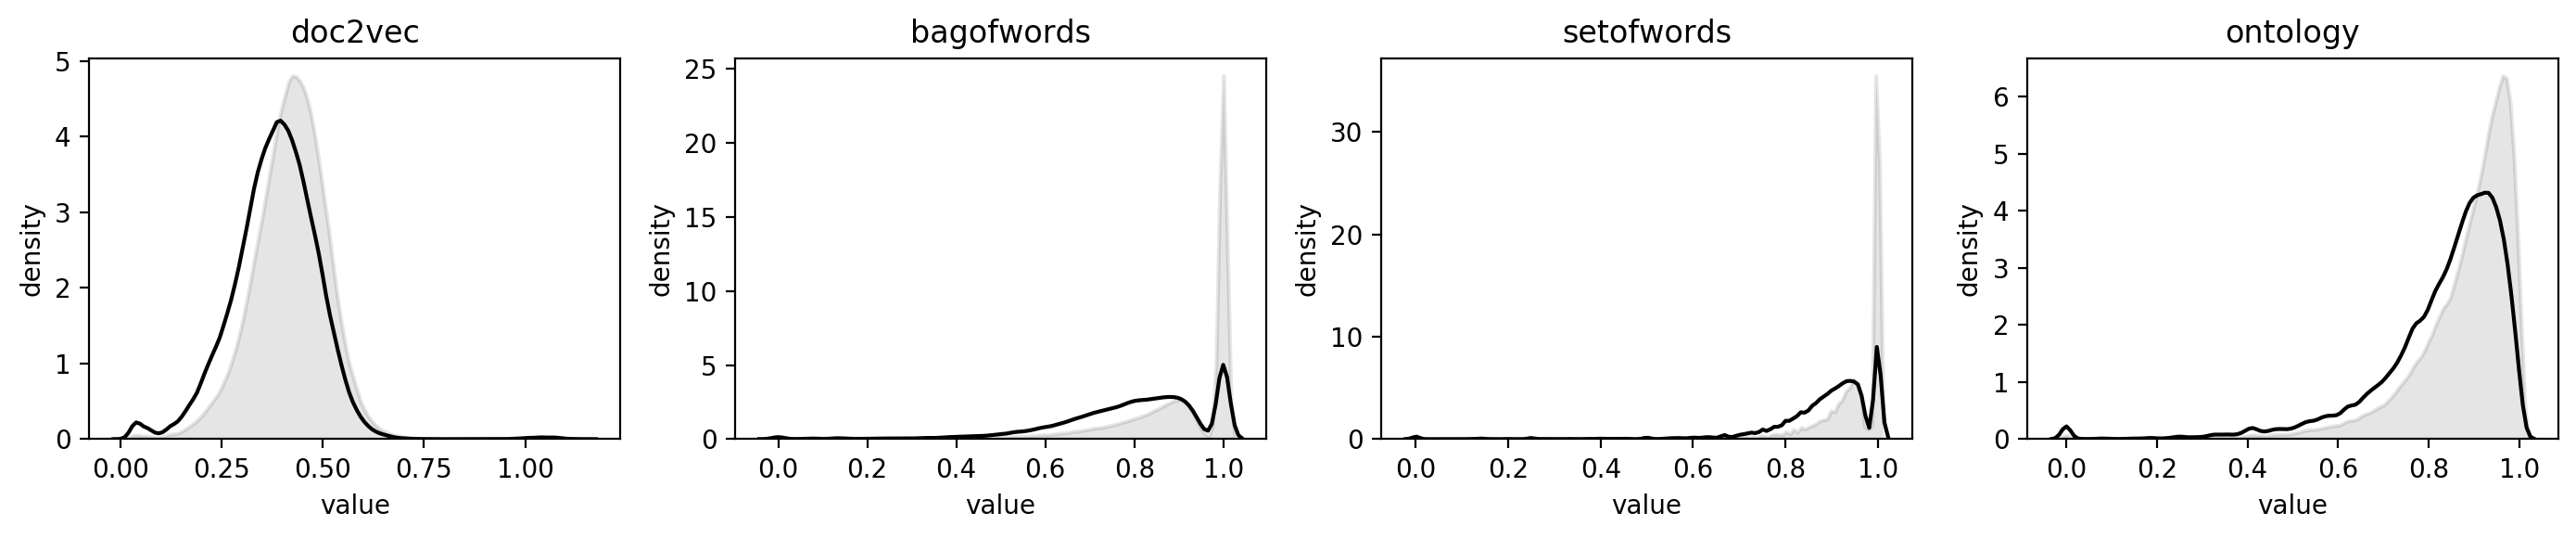

In [16]:
# Obtain the whole-data and within-group edge weight distributions by method.
METHODS = ["doc2vec", "bagofwords", "setofwords", "ontology"]
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(list)
within_weights_mean = {}
all_weights_dict = {}
for method in METHODS:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        within_weights_dict[method].extend(graph.get_values(within_pairs, kind=method)
                                           
                                        
                                           
                                           
# Plotting the kernel density estimates of the whole-data and within-group distributions.
num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(METHODS,axs.flatten()):
    ax.set_title(method)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(within_weights_dict[method], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(all_weights_dict[method], color="black", shade=True, alpha=0.1, ax=ax) 
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()